In [ ]:
from google.colab import drive
drive.mount("/content/drive")


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd 
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
from sklearn.preprocessing import scale 
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_auc_score,roc_curve
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

plt.rcParams['figure.figsize'] = (10, 7)

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
data=pd.read_csv('/content/drive/My Drive/Güncel Konular/veri/veri.csv',encoding="ISO-8859-1")
data_tarihsiz = data.select_dtypes(include=['float64'])
data_tarihsiz.head()

,PM10,SO2,CO,NO2,NOX,NO
0,21.417008,4.629833,605.988096,31.849611,46.945543,15.095931
1,20.477077,5.933857,800.393350,47.038542,77.533957,30.495416
2,38.253211,6.401385,911.299383,51.612556,98.944691,47.332137
3,35.534459,6.913496,952.646500,48.410507,82.663605,34.253095
4,39.670834,6.343282,1056.357483,47.683113,91.553461,43.870343


In [ ]:
data.dtypes

Tarih     object
PM10     float64
SO2      float64
CO       float64
NO2      float64
NOX      float64
NO       float64
dtype: object

In [ ]:
data_tarih = data.select_dtypes(include=['object'])
data_tarih.head()

,Tarih
0,1/1/2020
1,1/2/2020
2,1/3/2020
3,1/4/2020
4,1/5/2020


In [ ]:
data_tarihsiz.describe().T

,count,mean,std,min,25%,50%,75%,max
PM10,136.0,44.432776,26.712811,9.958241,25.114722,37.185330,55.674562,139.652997
SO2,136.0,5.738041,3.605287,1.113484,2.900947,5.199122,7.449457,18.423953
CO,136.0,875.498821,380.540060,407.386700,572.044346,784.988175,1088.569854,2116.150033
NO2,109.0,51.433578,20.822738,14.722220,34.523171,47.038542,64.147297,112.399083
NOX,109.0,97.882481,69.172506,15.922980,42.480553,74.769960,130.512952,333.211312
NO,109.0,46.460232,49.788061,1.200764,8.083986,25.419030,65.606022,232.664927


In [ ]:
from fancyimpute import KNN #KNN ile boş veri doldurma
var_tarih = list(data_tarih)
var_maddeler = list(data_tarihsiz)
knn_imp = KNN(k=7).fit_transform(data_tarihsiz);#knn ile boş değerleri doldurdum

Using TensorFlow backend.


Imputing row 1/136 with 0 missing, elapsed time: 0.006
Imputing row 101/136 with 0 missing, elapsed time: 0.006


In [ ]:
df = pd.DataFrame(knn_imp)
df.head()

,0,1,2,3,4,5
0,21.417008,4.629833,605.988096,31.849611,46.945543,15.095931
1,20.477077,5.933857,800.393350,47.038542,77.533957,30.495416
2,38.253211,6.401385,911.299383,51.612556,98.944691,47.332137
3,35.534459,6.913496,952.646500,48.410507,82.663605,34.253095
4,39.670834,6.343282,1056.357483,47.683113,91.553461,43.870343


In [ ]:
df.columns = var_maddeler
df = pd.concat([data_tarih, df], axis=1, sort=False)
df.head()

,Tarih,PM10,SO2,CO,NO2,NOX,NO
0,1/1/2020,21.417008,4.629833,605.988096,31.849611,46.945543,15.095931
1,1/2/2020,20.477077,5.933857,800.393350,47.038542,77.533957,30.495416
2,1/3/2020,38.253211,6.401385,911.299383,51.612556,98.944691,47.332137
3,1/4/2020,35.534459,6.913496,952.646500,48.410507,82.663605,34.253095
4,1/5/2020,39.670834,6.343282,1056.357483,47.683113,91.553461,43.870343


In [ ]:
df.isnull().sum()

Tarih    0
PM10     0
SO2      0
CO       0
NO2      0
NOX      0
NO       0
dtype: int64

In [ ]:
## So2 indeksi (si) hesaplama fonksiyonu
#Hava kalitesi indeksini hesaplamak için havadaki her bir maddenin indeksini hesapladım
#Aralıkları internetten aldım
def calculate_si(so2):
    si=0
    if (so2<=40):
     si= so2*(50/40)
    if (so2>40 and so2<=80):
     si= 50+(so2-40)*(50/40)
    if (so2>80 and so2<=380):
     si= 100+(so2-80)*(100/300)
    if (so2>380 and so2<=800):
     si= 200+(so2-380)*(100/800)
    if (so2>800 and so2<=1600):
     si= 300+(so2-800)*(100/800)
    if (so2>1600):
     si= 400+(so2-1600)*(100/800)
    return si
data['si']=data['SO2'].apply(calculate_si)
df= data[['SO2','si']]
df.head()

,SO2,si
0,4.629833,5.787291
1,5.933857,7.417321
2,6.401385,8.001732
3,6.913496,8.641870
4,6.343282,7.929103


In [ ]:
#No2 indeksi (ni) hesaplama fonksiyonu
def calculate_ni(no2):
    ni=0
    if(no2<=40):
     ni= no2*50/40
    elif(no2>40 and no2<=80):
     ni= 50+(no2-14)*(50/40)
    elif(no2>80 and no2<=180):
     ni= 100+(no2-80)*(100/100)
    elif(no2>180 and no2<=280):
     ni= 200+(no2-180)*(100/100)
    elif(no2>280 and no2<=400):
     ni= 300+(no2-280)*(100/120)
    else:
     ni= 400+(no2-400)*(100/120)
    return ni
data['ni']=data['NO2'].apply(calculate_ni)
df= data[['NO2','ni']]
df.head()

,NO2,ni
0,31.849611,39.812014
1,47.038542,91.298177
2,51.612556,97.015695
3,48.410507,93.013134
4,47.683113,92.103891


In [ ]:
#PM10 indeksi (rpi) hesaplama fonksiyonu
def calculate_(rspm):
    rpi=0
    if(rpi<=30):
     rpi=rpi*50/30
    elif(rpi>30 and rpi<=60):
     rpi=50+(rpi-30)*50/30
    elif(rpi>60 and rpi<=90):
     rpi=100+(rpi-60)*100/30
    elif(rpi>90 and rpi<=120):
     rpi=200+(rpi-90)*100/30
    elif(rpi>120 and rpi<=250):
     rpi=300+(rpi-120)*(100/130)
    else:
     rpi=400+(rpi-250)*(100/130)
    return rpi
data['rpi']=data['PM10'].apply(calculate_si)
df= data[['PM10','rpi']]
df.head()


,PM10,rpi
0,21.417008,26.771260
1,20.477077,25.596346
2,38.253211,47.816514
3,35.534459,44.418074
4,39.670834,49.588542


In [ ]:
#NO indeksi (spi) hesaplama fonksiyonu
def calculate_spi(spm):
    spi=0
    if(spm<=50):
     spi=spm
    if(spm<50 and spm<=100):
     spi=spm
    elif(spm>100 and spm<=250):
     spi= 100+(spm-100)*(100/150)
    elif(spm>250 and spm<=350):
     spi=200+(spm-250)
    elif(spm>350 and spm<=450):
     spi=300+(spm-350)*(100/80)
    else:
     spi=400+(spm-430)*(100/80)
    return spi
data['spi']=data['NO'].apply(calculate_spi)
df= data[['NO','spi']]
df.head()

,NO,spi
0,15.095931,15.095931
1,30.495416,30.495416
2,47.332137,47.332137
3,34.253095,34.253095
4,43.870343,43.870343


In [ ]:
#Her veri değerinin hava kalitesi indeksini (AQI) hesaplama fonksiyonu
def calculate_aqi(si,ni,spi,rpi):
    aqi=0
    if(si>ni and si>spi and si>rpi):
     aqi=si
    if(spi>si and spi>ni and spi>rpi):
     aqi=spi
    if(ni>si and ni>spi and ni>rpi):
     aqi=ni
    if(rpi>si and rpi>ni and rpi>spi):
     aqi=rpi
    return aqi
data['AQI']=data.apply(lambda x:calculate_aqi(x['si'],x['ni'],x['spi'],x['rpi']),axis=1)

data = data[['Tarih', 'si', 'ni', 'spi', 'rpi', 'AQI']]
data.dtypes
 

Tarih     object
si       float64
ni       float64
spi      float64
rpi      float64
AQI      float64
dtype: object

In [ ]:
data_tarihsiz = data.select_dtypes(include=['float64'])
data_tarihsiz.head()

,si,ni,spi,rpi,AQI
0,5.787291,39.812014,15.095931,26.771260,39.812014
1,7.417321,91.298177,30.495416,25.596346,91.298177
2,8.001732,97.015695,47.332137,47.816514,97.015695
3,8.641870,93.013134,34.253095,44.418074,93.013134
4,7.929103,92.103891,43.870343,49.588542,92.103891


In [ ]:
data_tarihsiz.describe().T

,count,mean,std,min,25%,50%,75%,max
si,136.0,7.172551,4.506609,1.391855,3.626184,6.498902,9.311821,23.029942
ni,109.0,82.112681,33.107680,18.402775,43.153964,91.298177,108.963090,132.399083
spi,109.0,22.317787,54.688023,-74.104776,3.576287,11.154170,33.369160,188.443284
rpi,136.0,53.057102,26.976914,12.447801,31.393403,46.481663,69.593203,119.884332
AQI,136.0,68.568407,47.181461,0.000000,34.634519,84.362302,107.956724,188.443284


In [ ]:
data_tarih = data.select_dtypes(include=['object'])
data_tarih.head()


,Tarih
0,1/1/2020
1,1/2/2020
2,1/3/2020
3,1/4/2020
4,1/5/2020


In [ ]:
from fancyimpute import KNN #KNN ile boş veri doldurma
var_tarih = list(data_tarih)
var_maddeler = list(data_tarihsiz)
knn_imp = KNN(k=7).fit_transform(data_tarihsiz);#knn ile boş değerleri doldurdum

Imputing row 1/136 with 0 missing, elapsed time: 0.009
Imputing row 101/136 with 0 missing, elapsed time: 0.010


In [ ]:
df = pd.DataFrame(knn_imp)
df.head()

,0,1,2,3,4
0,5.787291,39.812014,15.095931,26.771260,39.812014
1,7.417321,91.298177,30.495416,25.596346,91.298177
2,8.001732,97.015695,47.332137,47.816514,97.015695
3,8.641870,93.013134,34.253095,44.418074,93.013134
4,7.929103,92.103891,43.870343,49.588542,92.103891


In [ ]:
df.columns = var_maddeler
df = pd.concat([data_tarih, df], axis=1, sort=False)
df.head()

,Tarih,si,ni,spi,rpi,AQI
0,1/1/2020,5.787291,39.812014,15.095931,26.771260,39.812014
1,1/2/2020,7.417321,91.298177,30.495416,25.596346,91.298177
2,1/3/2020,8.001732,97.015695,47.332137,47.816514,97.015695
3,1/4/2020,8.641870,93.013134,34.253095,44.418074,93.013134
4,1/5/2020,7.929103,92.103891,43.870343,49.588542,92.103891


In [ ]:
df.isnull().sum()

Tarih    0
si       0
ni       0
spi      0
rpi      0
AQI      0
dtype: int64

In [ ]:
#Nan değerleri silme işlemi
df = df[:-26]
dataset_test = df


In [ ]:
dataset_test.dtypes

Tarih     object
si       float64
ni       float64
spi      float64
rpi      float64
AQI      float64
dtype: object

In [ ]:
df = df[['si', 'ni', 'spi', 'rpi', 'AQI']]
#Hedef sütun
y = df['AQI']
X = df.drop(['AQI'], axis=1).astype('float64')
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25, 
                                                    random_state=42)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
rf_model = RandomForestRegressor(random_state = 42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [ ]:
#Yarısını test yarısını eğitim olarak ayırdım
rf_model.predict(X_test)[0:5]
y_pred = rf_model.predict(X_test)

In [ ]:
np.sqrt(mean_squared_error(y_test, y_pred))

3.9427964881284554

In [ ]:
# Modelin oluşturulamasında en iyi parametreleri bulmak için modeli tuning işlemine tabi tuttum.
rf_params = {'max_depth': list(range(1,10)),
            'max_features': [3,5,10,15],
            'n_estimators' : [100, 200, 500, 1000, 2000]}
            #500 ve 1000 bilimsel anlamda iyi sayılarmış rf için

In [ ]:
rf_model = RandomForestRegressor(random_state = 42)

In [ ]:
rf_cv_model = GridSearchCV(rf_model, 
                           rf_params, 
                           cv = 10, 
                            n_jobs = -1)# CPU full çalışır bunu yazarsan

In [ ]:
rf_cv_model.fit(X_train, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_job

In [ ]:
#Buradan gelen verilerle modeli oluşturup modeli eğittim
rf_cv_model.best_params_

{'max_depth': 6, 'max_features': 3, 'n_estimators': 200}

In [ ]:
rf_tuned = RandomForestRegressor(max_depth  = 6, 
                                 max_features = 3, 
                                 n_estimators =200)

In [ ]:
rf_tuned.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=6, max_features=3, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=200, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
#Tahmin karşılaştırma
y_pred = rf_tuned.predict(X_test)

In [ ]:
rf_tuned.score(X_test,y_test)# Başarım

0.9842725126829529

In [ ]:
np.sqrt(mean_squared_error(y_test, y_pred))
#Hata Kare Ortalaması : Tahmin edilen değerler gerçek değerlere ne kadar yakınsa Hata Kare Ortalaması o kadar küçük olur; 
#gerçek değerlerden ne kadar uzaklaşırsa Hata Kare Ortalaması o kadar büyük olur. 


4.473599963299146

In [ ]:
#Hava kalitesi indeksini en çok etkileyen veriyi aşağıda gösterdim 
Importance = pd.DataFrame({"Önem Derecesi": rf_tuned.feature_importances_*100},
                         index = X_train.columns)

Text(0.5, 0, 'Değişken Önem Düzeyleri')

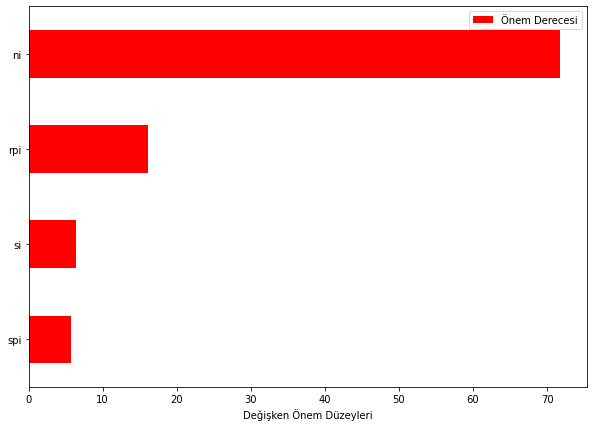

In [ ]:
Importance.sort_values(by = "Önem Derecesi", 
                       axis = 0, 
                       ascending = True).plot(kind ="barh", color = "r")

plt.xlabel("Değişken Önem Düzeyleri")

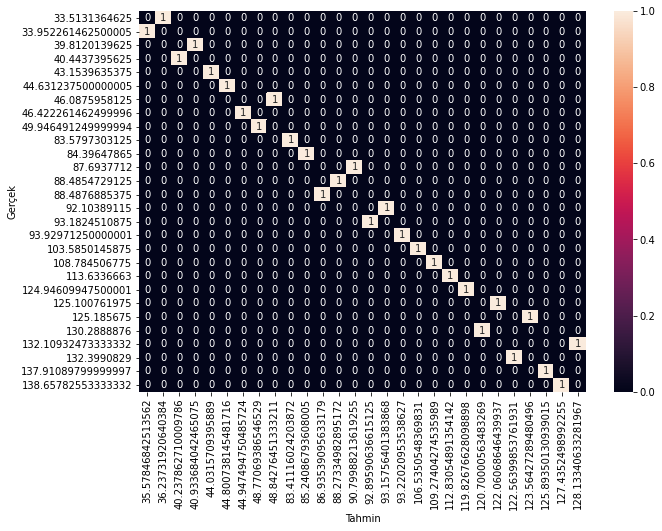

In [ ]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

data = {'Gerçek':    list(y_test),
        'Tahmin': list(y_pred)
        }

df = pd.DataFrame(data, columns=['Gerçek','Tahmin'])
confusion_matrix = pd.crosstab(df['Gerçek'], df['Tahmin'], rownames=['Gerçek'], colnames=['Tahmin'])

sn.heatmap(confusion_matrix, annot=True)
plt.show()

In [ ]:
df.head()

In [ ]:
dataset_test.head()

,Tarih,si,ni,spi,rpi,AQI
0,1/1/2020,5.787291,39.812014,15.095931,26.771260,39.812014
1,1/2/2020,7.417321,91.298177,30.495416,25.596346,91.298177
2,1/3/2020,8.001732,97.015695,47.332137,47.816514,97.015695
3,1/4/2020,8.641870,93.013134,34.253095,44.418074,93.013134
4,1/5/2020,7.929103,92.103891,43.870343,49.588542,92.103891


In [ ]:
dfaa = pd.concat([dataset_test['Tarih'], df], axis=1, sort=False)

In [ ]:
dfaa["Tarih"] = pd.to_datetime(dfaa["Tarih"])

In [ ]:
dfaaa = dfaa[:-82]

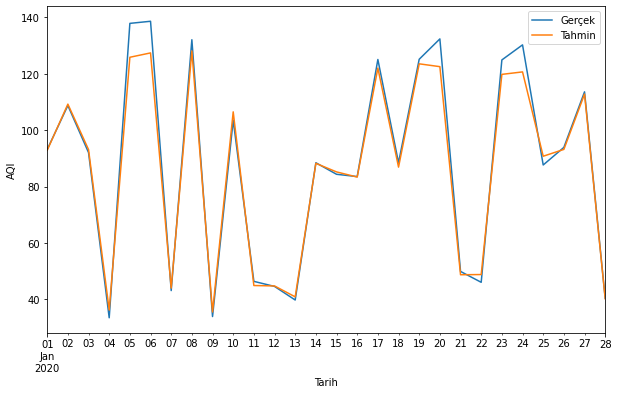

In [ ]:
dff=dfaaa.set_index('Tarih')
dff.sort_values(by='Tarih',ascending=False)
dff.plot(figsize=(10, 6))
plt.ylabel("AQI")
y=dff.Gerçek

In [ ]:
y_testt = np.array([93.182451, 108.784507, 92.103891, 33.513136, 137.910898, 138.657826, 43.153964,
          132.109325, 33.952261, 103.585015, 46.422261, 44.631238, 39.812014, 88.485473,
           84.396479, 83.579730, 125.100762, 88.487689, 125.185675, 132.399083, 49.946491, 
           46.087596, 124.946099, 130.288888, 87.693771, 93.929713, 113.633666,40.443740])

In [ ]:
#Tam sayı dönüşümü
y_testt = np.around(y_testt)
y_testt = y_testt.astype(int)
y_testt

array([ 93, 109,  92,  34, 138, 139,  43, 132,  34, 104,  46,  45,  40,
        88,  84,  84, 125,  88, 125, 132,  50,  46, 125, 130,  88,  94,
       114,  40])

In [ ]:
y_pred = np.around(y_pred)
y_pred = y_pred.astype(int)
y_pred

array([ 93, 109,  93,  36, 126, 127,  44, 128,  36, 107,  45,  45,  41,
        88,  85,  83, 122,  87, 124, 123,  49,  49, 120, 121,  91,  93,
       113,  40])

In [ ]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

# Model Değerlendirmesi

pre = precision_score(y_testt, y_pred, average='weighted')
recall = recall_score(y_testt, y_pred,average='weighted')
f1 = f1_score(y_testt, y_pred, average='weighted')

#Getirilen bilgideki doğru sonuçların, getirilen bilginin tamamına oranı olarak hesaplanır.
print("Kesinlik : %f "% pre)

#Getirilen doğru sonuçların, getirilmesi gereken doğru sonuçlara oranı ile hesaplanır.
print("Hassasiyet: %f " % recall)

#F1 skoru, bu değerlerin(kesinlik ve hassasiyet) harmonik ortalamasıdır
print('F1 Skor: %f' % f1)


Kesinlik : 0.244048 
Hassasiyet: 0.178571 
F1 Skor: 0.178571
